In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import xarray as xr
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
from keras.models import load_model
from keras.utils import plot_model
from deepsky.gan import gan_loss, rescale_data, rescale_multivariate_data, unscale_multivariate_data
from IPython.display import Image
from netCDF4 import Dataset
import h5py
from os.path import join

Using TensorFlow backend.


In [59]:
def load_storm_patch_data(data_path, variable_names):
    data_patches = []
    data_files = sorted(glob(join(data_path, "*20160526*.nc")))
    for data_file in data_files:
        print(data_file.split("/")[-1])
        ds = xr.open_dataset(data_file)
        patch_arr = []
        for variable in variable_names:
            patch_arr.append(ds[variable].values)
        data_patches.append(np.stack(patch_arr, axis=-1))
    data = np.vstack(data_patches)
    return data

In [14]:
def load_storm_patch_data(data_path, variable_names):
    data_patches = []
    centers = []
    valid_dates = []
    data_files = sorted(glob(join(data_path, "*20160526*.nc")))
    for data_file in data_files:
        print(data_file)
        ds = xr.open_dataset(data_file)
        patch_arr = []
        all_vars = list(ds.variables.keys())
        if np.all(np.in1d(variable_names, all_vars)):
            centers.append(np.array([ds["longitude"][:, 32, 32], ds["latitude"][:, 32, 32]]).T)
            valid_dates.append(ds["valid_date"].values)
            for variable in variable_names:
                patch_arr.append(ds[variable][:, 16:-16, 16:-16].values)
            data_patches.append(np.stack(patch_arr, axis=-1))
        ds.close()
    center_arr = np.vstack(centers)
    valid_date_index = pd.DatetimeIndex(np.concatenate(valid_dates))
    data = np.vstack(data_patches)
    return data, center_arr, valid_date_index

In [16]:
data_path = "/scratch/dgagne/ncar_ens_storm_patches/"
#variable_names = ["composite_reflectivity_entire_atmosphere_prev",
#                  "temperature_2_m_above_ground_prev",
#                  "dew_point_temperature_2_m_above_ground_prev",
#                  "u-component_of_wind_10_m_above_ground_prev",
#                  "v-component_of_wind_10_m_above_ground_prev"]
variable_names = ['composite_reflectivity_entire_atmosphere_current',
                  'precipitable_water_entire_atmosphere_(considered_as_a_single_layer)_current',
                  'geopotential_height_level_of_adiabatic_condensation_from_sfc_prev',
                  'convective_available_potential_energy_180-0_mb_above_ground_prev',
                  'vertical_u-component_shear_0-6000_m_above_ground_prev',
                  'vertical_v-component_shear_0-6000_m_above_ground_prev',
                  ]
storm_data, storm_centers, storm_dates = load_storm_patch_data(data_path, variable_names)
scaled_storm_data = rescale_multivariate_data(storm_data)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_02.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_03.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_04.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_05.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_06.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_07.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_08.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_09.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_10.nc


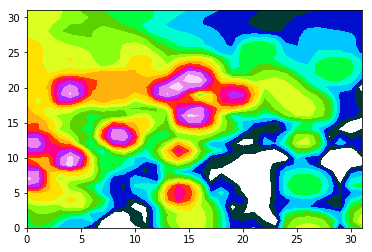

In [17]:
plt.contourf(storm_data[203, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")

In [3]:
gan_history_files = sorted(glob("/scratch/dgagne/storm_gan_20170622/gan_loss_history_*.csv"))
gan_history_coll = []
for gan_history_file in gan_history_files:
    print(gan_history_file)
    gan_history_coll.append(pd.read_csv(gan_history_file, index_col="Time", parse_dates=["Time"]))

/scratch/dgagne/storm_gan_20170622/gan_loss_history_000.csv
/scratch/dgagne/storm_gan_20170622/gan_loss_history_001.csv
/scratch/dgagne/storm_gan_20170622/gan_loss_history_002.csv
/scratch/dgagne/storm_gan_20170622/gan_loss_history_003.csv
/scratch/dgagne/storm_gan_20170622/gan_loss_history_004.csv
/scratch/dgagne/storm_gan_20170622/gan_loss_history_005.csv


[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]
[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]
[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]
[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]
[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]
[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]


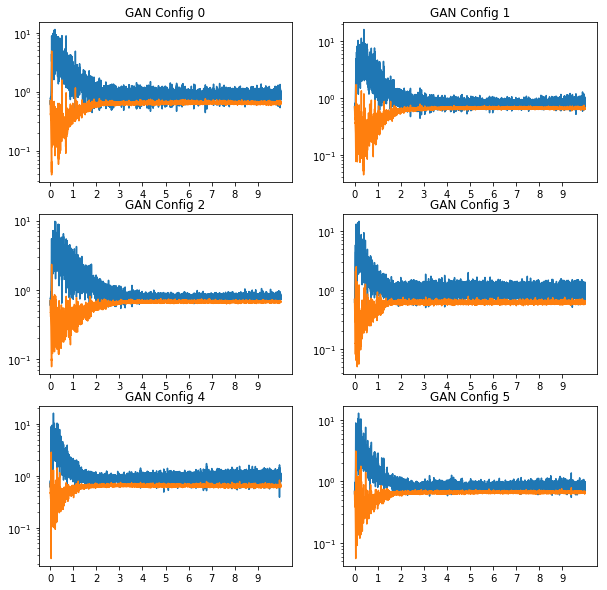

In [128]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))
axef = axes.ravel()
for g in range(len(gan_history_coll)):
    axef[g].plot(np.arange(gan_history_coll[g].shape[0]), gan_history_coll[g]["Gen Loss"])
    axef[g].plot(np.arange(gan_history_coll[g].shape[0]), gan_history_coll[g]["Disc Loss"])
    epoch_vals = np.where(gan_history_coll[g]["Batch"].values == 0)[0]
    print(epoch_vals)
    axef[g].set_xticks(epoch_vals)
    axef[g].set_xticklabels(gan_history_coll[g].iloc[epoch_vals]["Epoch"].values.astype(int) - 1)
    axef[g].set_yscale("log")
    axef[g].set(title="GAN Config {0:d}".format(g))

In [10]:
for c in range(5):
    print(gan_history_coll[c].index[-1] - gan_history_coll[c].index[0])

0 days 00:45:04.561501
0 days 00:45:08.052215
0 days 00:46:08.525050
0 days 02:04:46.181173
0 days 02:04:49.856752


[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]
[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]
[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]
[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]
[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]
[   0  882 1764 2646 3528 4410 5292 6174 7056 7938]


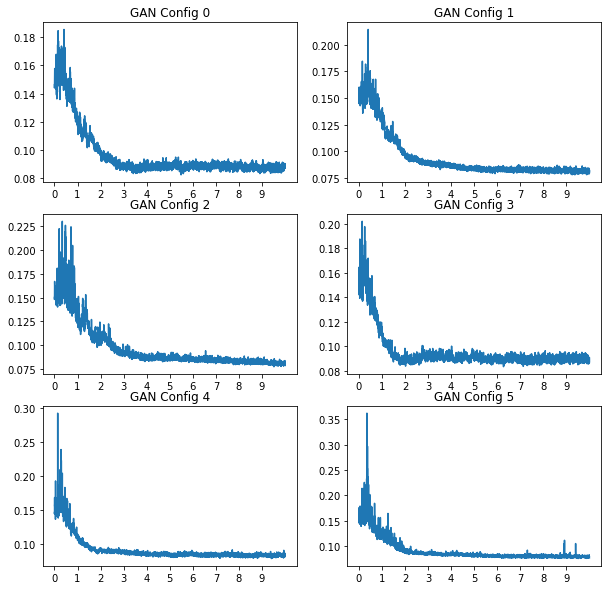

In [6]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))
axef = axes.ravel()
for g in range(len(gan_history_coll)):
    axef[g].plot(np.arange(gan_history_coll[g].shape[0]), gan_history_coll[g]["Gen_Enc Loss"])
    epoch_vals = np.where(gan_history_coll[g]["Batch"].values == 0)[0]
    print(epoch_vals)
    axef[g].set_xticks(epoch_vals)
    axef[g].set_xticklabels(gan_history_coll[g].iloc[epoch_vals]["Epoch"].values.astype(int) - 1)
    #axef[g].set_yscale("log")
    axef[g].set(title="GAN Config {0:d}".format(g))

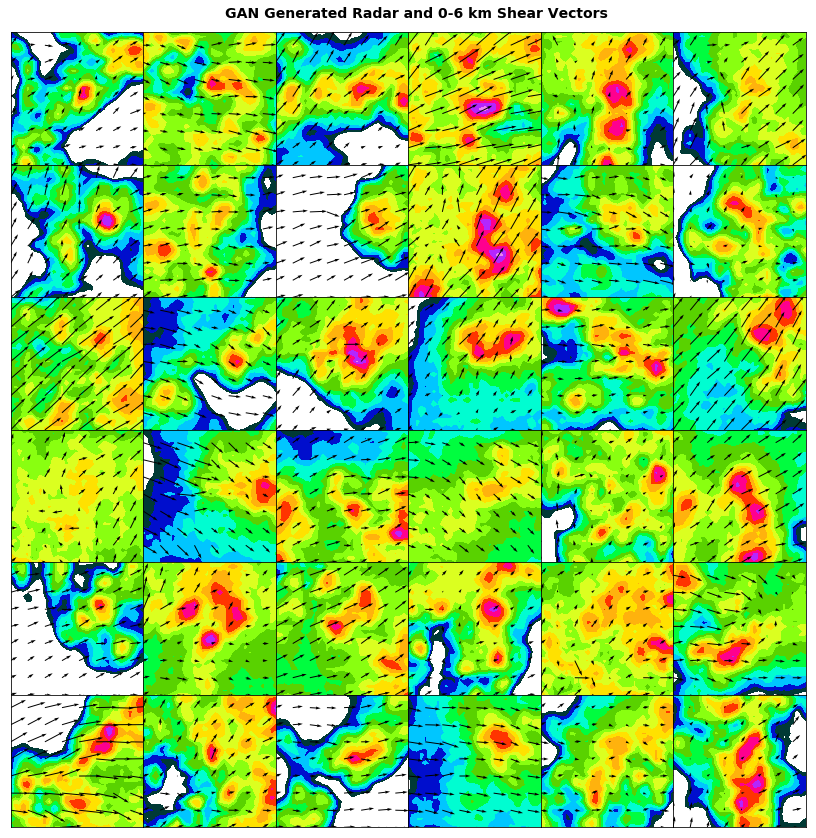

In [105]:
ds = xr.open_dataset("/scratch/dgagne/storm_gan_20170622/gan_gen_patches_004_epoch_010.nc")
fig, axes = plt.subplots(6,6, figsize=(12, 12))
plt.subplots_adjust(0.03, 0.03, 0.95, 0.95, wspace=0, hspace=0)

axef = axes.ravel()
for a, ax in enumerate(axef):
    ax.contourf(ds["gen_patch"][a, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")
    ax.quiver(np.arange(0, 32, 4), np.arange(0, 32, 4), 
              ds["gen_patch"][a, ::4, ::4, -2], 
              ds["gen_patch"][a, ::4, ::4, -1], scale=150)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
fig.suptitle("GAN Generated Radar and 0-6 km Shear Vectors", fontsize=14, fontweight="bold")
ds.close()

In [9]:
gan_param_configs = pd.read_csv("/scratch/dgagne/storm_gan_20170622/gan_param_combos.csv")
gan_param_configs

,Index,min_data_width,filter_width,beta_one,min_conv_filters,generator_input_size,learning_rate,batch_size
0,0,4,5,0.2,64,16,0.0001,256
1,1,4,5,0.2,64,32,0.0001,256
2,2,4,5,0.2,64,128,0.0001,256
3,3,4,5,0.2,128,16,0.0001,256
4,4,4,5,0.2,128,32,0.0001,256
5,5,4,5,0.2,128,128,0.0001,256


In [11]:

enc= load_model("/scratch/dgagne/storm_gan_20170622/gan_encoder_000004_epoch_0010.h5")
gen = load_model("/scratch/dgagne/storm_gan_20170622/gan_generator_000004_epoch_0010.h5")

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-2.0.6-py3.5.egg/keras/models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


In [13]:
print(enc.summary())
print(gen.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       19328     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         3277312   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4, 4, 512)         0         
__________

In [18]:
max_vals = storm_data.max(axis=0).max(axis=0).max(axis=0)
min_vals = storm_data.min(axis=0).min(axis=0).min(axis=0)

In [19]:
enc_vecs = enc.predict(scaled_storm_data[104:204])
regen = unscale_multivariate_data(gen.predict(enc_vecs), min_vals, max_vals)

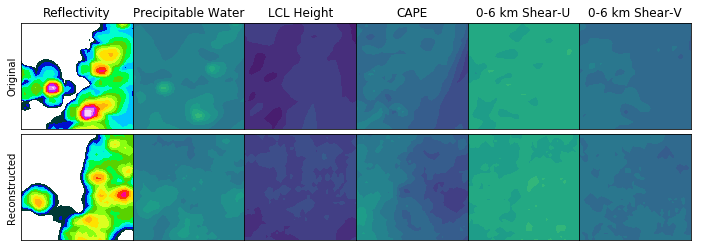

In [118]:
fig, axes = plt.subplots(2, 6, figsize=(12, 4))
plt.subplots_adjust(wspace=0, hspace=0.05)
short_var_names = ["Reflectivity", "Precipitable Water", "LCL Height", "CAPE", "0-6 km Shear-U", "0-6 km Shear-V"]
axes[0, 0].contourf(storm_data[105, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")
axes[1, 0].contourf(regen[1, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")
axes[0, 0].set_ylabel("Original")
axes[1, 0].set_ylabel("Reconstructed")
axes[0, 0].set_title(short_var_names[0])
axes[0, 0].axes.get_xaxis().set_ticks([])
axes[0, 0].axes.get_yaxis().set_ticks([])
axes[1, 0].axes.get_xaxis().set_ticks([])
axes[1, 0].axes.get_yaxis().set_ticks([])
for var in range(1, 6):
    axes[0, var].contourf(storm_data[105, :, :, var], np.linspace(min_vals[var], max_vals[var], 20))
    axes[1, var].contourf(regen[1, :, :, var],np.linspace(min_vals[var], max_vals[var], 20))
    axes[0, var].set_title(short_var_names[var])
    axes[0, var].axes.get_xaxis().set_ticks([])
    axes[0, var].axes.get_yaxis().set_ticks([])
    axes[1, var].axes.get_xaxis().set_ticks([])
    axes[1, var].axes.get_yaxis().set_ticks([])

In [124]:
interp_vecs = np.zeros((12, enc_vecs.shape[1]))
interp_vecs[0] = enc_vecs[0]
interp_vecs[-1] = enc_vecs[-50]
for i in range(interp_vecs.shape[1]):
    interp_vecs[:, i] = np.linspace(interp_vecs[0, i], interp_vecs[-1, i], 12)

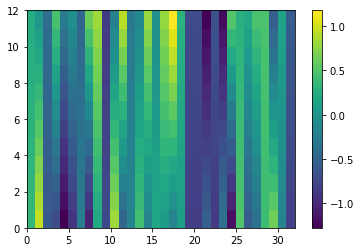

In [125]:
plt.pcolormesh(interp_vecs)
plt.colorbar()

In [126]:
interp_regen = unscale_multivariate_data(gen.predict(interp_vecs), min_vals, max_vals)

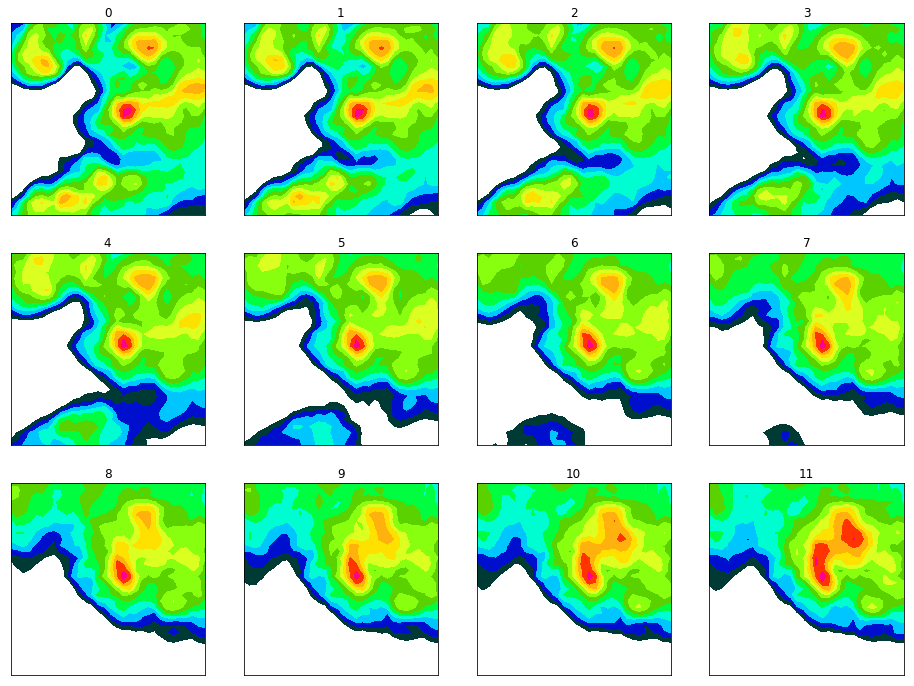

In [127]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axef = axes.ravel()
for a, ax in enumerate(axef):
    ax.contourf(interp_regen[a, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_title(a)

In [36]:
input_const_vecs = np.tile(np.linspace(-3, 3, 20), 32).reshape(32, 20).T
print(input_const_vecs)

[[-3.         -3.         -3.         -3.         -3.         -3.         -3.
  -3.         -3.         -3.         -3.         -3.         -3.         -3.
  -3.         -3.         -3.         -3.         -3.         -3.         -3.
  -3.         -3.         -3.         -3.         -3.         -3.         -3.
  -3.         -3.         -3.         -3.        ]
 [-2.68421053 -2.68421053 -2.68421053 -2.68421053 -2.68421053 -2.68421053
  -2.68421053 -2.68421053 -2.68421053 -2.68421053 -2.68421053 -2.68421053
  -2.68421053 -2.68421053 -2.68421053 -2.68421053 -2.68421053 -2.68421053
  -2.68421053 -2.68421053 -2.68421053 -2.68421053 -2.68421053 -2.68421053
  -2.68421053 -2.68421053 -2.68421053 -2.68421053 -2.68421053 -2.68421053
  -2.68421053 -2.68421053]
 [-2.36842105 -2.36842105 -2.36842105 -2.36842105 -2.36842105 -2.36842105
  -2.36842105 -2.36842105 -2.36842105 -2.36842105 -2.36842105 -2.36842105
  -2.36842105 -2.36842105 -2.36842105 -2.36842105 -2.36842105 -2.36842105
  -2.36842105 -2.3

In [37]:
output_const_vecs = enc.predict(gen.predict(input_const_vecs))

In [38]:
output_const_vecs[15]

array([ 1.11779058,  1.6583358 ,  0.97250569,  0.86662966,  2.06795669,
        1.79675877,  1.00473166, -0.33920911,  1.73172021,  1.93713498,
        0.42086467,  0.68718332,  1.52318931,  1.71872222,  0.69499069,
        0.22015247,  0.8377586 ,  2.15822744,  1.63234901,  1.00051332,
        1.10312843,  1.24736011,  1.19796717,  0.17347518,  1.90797532,
        0.51732159,  1.28010345, -0.20726927,  0.64307839,  0.75743586,
        0.37840781,  0.78744537], dtype=float32)

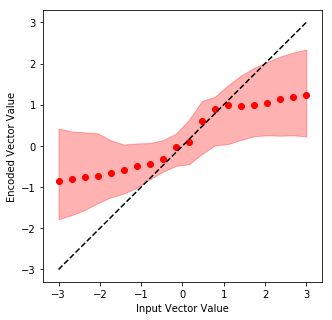

In [60]:
plt.figure(figsize=(5, 5))
plt.fill_between(input_const_vecs.mean(axis=1), np.percentile(output_const_vecs, 90, axis=1), 
                     np.percentile(output_const_vecs, 10, axis=1), color='r', alpha=0.3)
plt.scatter(np.mean(input_const_vecs, axis=1), np.median(output_const_vecs, axis=1), color='r')

plt.plot(np.arange(-3, 3.1, 0.1), np.arange(-3, 3.1, 0.1), 'k--')
plt.xlabel("Input Vector Value")
plt.ylabel("Encoded Vector Value")
plt.title("")

In [40]:
plot_model(enc, to_file="/scratch/dgagne/storm_gan_20170622/gan_encoder_000.png", show_shapes=True)

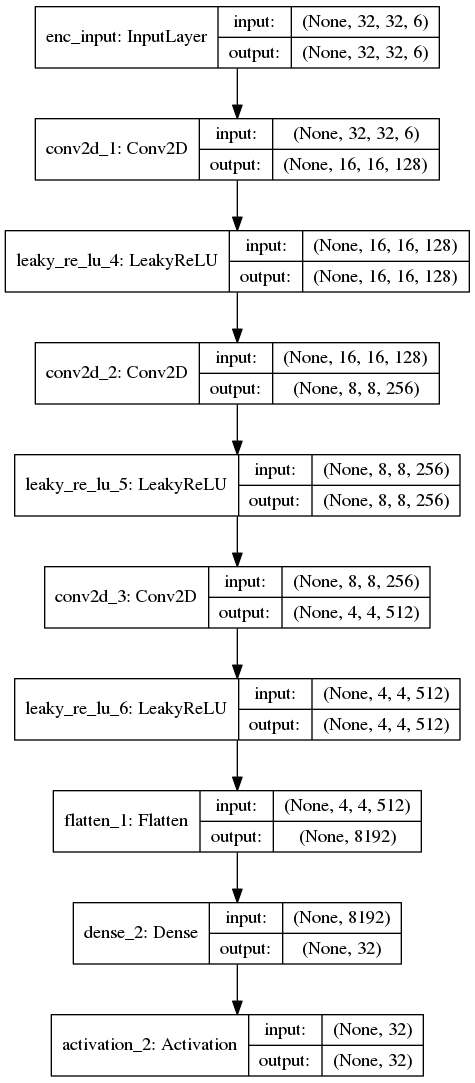

In [43]:
Image("/scratch/dgagne/storm_gan_20170622/gan_encoder_000.png")

In [32]:
d = h5py.File("/scratch/dgagne/storm_gan_20170519/gan_encoder_000001_epoch_0010.h5")

In [44]:
dir(d)

['_MutableMapping__marker',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_d',
 '_e',
 '_id',
 '_lapl',
 '_lcpl',
 'attrs',
 'clear',
 'close',
 'copy',
 'create_dataset',
 'create_group',
 'driver',
 'fid',
 'file',
 'filename',
 'flush',
 'get',
 'id',
 'items',
 'keys',
 'libver',
 'mode',
 'move',
 'name',
 'parent',
 'pop',
 'popitem',
 'ref',
 'regionref',
 'require_dataset',
 'require_group',
 'setdefault',
 'upd

In [46]:
for key in d.keys():
    print(key)

model_weights
optimizer_weights


In [66]:
list(d["model_weights"].keys())

['activation_10',
 'activation_6',
 'activation_7',
 'activation_8',
 'activation_9',
 'conv2d_1',
 'conv2d_2',
 'conv2d_3',
 'conv2d_4',
 'dense_2',
 'enc_input',
 'flatten_1']

In [77]:
list(d["model_weights"]["conv2d_1"]["conv2d_1"].keys())

['bias:0', 'kernel:0']